In [1]:
%load_ext autoreload
%autoreload 2

import itertools

import torch
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
# from allennlp.data.token_indexers.bert_tokenizers import PretrainedBertIndexer

from awesome_sst.task import Task
from awesome_sst.config import Config

from luna import ram_write, chunks
from allennlpx import allenutil
from openTSNE import TSNE as OTSNE
from openTSNE.callbacks import ErrorLogger

from adjustText import adjust_text


In [21]:
class Config:
    def __init__(self):
        super().__init__()
        self.pretrain = "bert"
        self.fix_embed = False
        # self.mode = 'train'

        self.layer_noise = 0.0
        self.embed_noise = 0.0
        self.lstm_noise = 0.0

config = Config()        
ram_write("config", config)

task = Task(config) # type: Task
task.from_trained()


cache for bert_data exists
*** load bert_data from cache cost 4.28 seconds
cache for bert_vocab does not exist



*** create bert_vocab and save to cache cost 0.452 seconds
LstmClassifier(
  (word_embedders): BasicTextFieldEmbedder(
    (token_embedder_tokens): PretrainedBertEmbedder(
      (bert_model): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): BertLayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0): BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
             

In [21]:
# next(zip(*list(task.model.named_parameters())))

In [23]:
@torch.no_grad()
def get_internals(sent='hello world', inc=False):
    sent = sent.split(" ")
    inc_sents = []
    if inc:
        for ti in range(1, len(sent) + 1):
            inc_sents.append({"sentence": allenutil.as_sentence(sent[:ti])})
    else:
        inc_sents.append({"sentence": allenutil.as_sentence(sent)})
    sent_embeds = []
    sent_preds = []
    with task.predictor.capture_named_internals(tgt_module) as internals:
        outputs = task.predictor.predict_batch_json(inc_sents)
        if config.pretrain=='bert':
            sent_embeds.append(internals[tgt_module][:, 0]) # GET [CLS]
        else:
            sent_embeds.append(internals[tgt_module])
    for i, ele in enumerate(outputs):
        sent_preds.append(ele['probs'][idx_1] > ele['probs'][idx_0])
    sent_embeds = torch.cat(sent_embeds, dim=0)
    return sent_embeds, sent_preds

In [34]:
class TSNEPlotter:
    def __init__(self, embeds: np.ndarray, mask, base_num: int, annotations):
        self.embeds = embeds
        self.mask = mask
        self.base_num = base_num
        otsne = OTSNE(initialization='pca', negative_gradient_method='bh')
        self.points = otsne.fit(self.embeds)
        self.annotations = annotations
        
    def plot(self):
        plt.rcParams['figure.figsize'] = [5, 5]
        bases = self.points[:self.base_num]
        pos_mask = np.array(self.mask[:self.base_num])
        plt.scatter(bases[:, 0][pos_mask], bases[:, 1][pos_mask], c='#00FF0020', label='pos', marker='+')
        plt.scatter(bases[:, 0][~pos_mask], bases[:, 1][~pos_mask], c='#FF000020', label='neg', marker='+')   
        
        news = self.points[self.base_num:]
        pos_mask = self.mask[self.base_num:]
        texts = []
        for idx in range(news.shape[0]):
            plt.scatter(news[idx, 0], news[idx, 1], c='g' if pos_mask[idx] else 'r', marker='x', s=10)
            texts.append(plt.text(news[idx, 0], news[idx, 1], 
                                  self.annotations[idx], 
                                  ha='center', va='center'))
        adjust_text(texts)
        plt.legend()
    

In [73]:
idx_1 = task.vocab.get_token_index('1', 'labels')
idx_0 = task.vocab.get_token_index('0', 'labels')


if config.pretrain == 'bert':
#     tgt_module = "word_embedders.token_embedder_tokens.bert_model.pooler.activation"
    tgt_module = "word_embedders.token_embedder_tokens.bert_model.encoder.layer.10"
else:
    tgt_module = "encoder"

with torch.no_grad():
    sst_embeds = []
    sst_preds = []
    sst_labels = []
    for instances in chunks(task.test_data, 300):
        with task.predictor.capture_named_internals(tgt_module) as internals:
            outputs = task.predictor.predict_batch_instance(instances)
            if config.pretrain == 'bert':
                sst_embeds.append(internals[tgt_module][:, 0]) # GET [CLS]
            else:
                sst_embeds.append(internals[tgt_module])
        
        for i, ele in enumerate(outputs):
            sst_preds.append(ele['probs'][idx_1] > ele['probs'][idx_0])
        for instance in instances:
            sst_labels.append(instance.fields['label'].label == '1')
    sst_embeds = torch.cat(sst_embeds, dim=0)
torch.cuda.empty_cache()
# sst_embeds.size()
# otsne = OTSNE(initialization='pca', negative_gradient_method='bh')
# sst2ds = otsne.fit(sst_embeds.cpu().numpy())
# plt.rcParams['figure.figsize'] = [5, 5]
# plt.scatter(sst2ds[:, 0][np.array(sst_labels)], sst2ds[:, 1][np.array(sst_labels)], c='#00FF0020', label='pos', marker='+')
# plt.scatter(sst2ds[:, 0][~np.array(sst_labels)], sst2ds[:, 1][~np.array(sst_labels)], c='#FF000020', label='neg', marker='+')

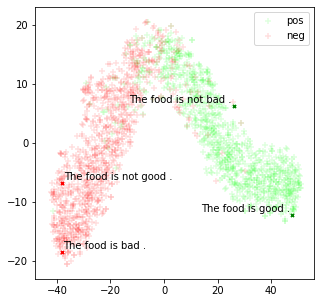

In [74]:
# allenutil.as_sentence(instance)
mysents = [
    "The food is good .",
    "The food is bad .",
    "The food is not good .",
    "The food is not bad .",    
]
my_embeds = []
my_preds = []
for sent in mysents:
    embed, pred = get_internals(sent)
    my_embeds.append(embed)
    my_preds.extend(pred)
my_embeds = torch.cat(my_embeds, dim=0)

all_embeds = np.concatenate([sst_embeds.cpu().numpy(), my_embeds.cpu().numpy()])

plotter = TSNEPlotter(all_embeds, 
                      mask = sst_labels + my_preds,
                      base_num =sst_embeds.shape[0], 
                      annotations=mysents
#                       annotations=[str(idx) for idx in range(len(mysents))]
                     )
plotter.plot()


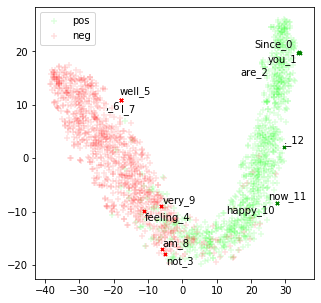

In [42]:
# allenutil.as_sentence(instance)
mysents = ["Since you are not feeling well , I am very happy now ."]
annots = [f"{ele}_{i}" for sent in mysents for i, ele in enumerate(sent.split(" "))]
my_embeds = []
my_preds = []
for sent in mysents:
    embed, pred = get_internals(sent, inc=True)
    my_embeds.append(embed)
    my_preds.extend(pred)
my_embeds = torch.cat(my_embeds, dim=0)

all_embeds = np.concatenate([sst_embeds.cpu().numpy(), my_embeds.cpu().numpy()])

plotter = TSNEPlotter(all_embeds, 
                      mask = sst_labels + my_preds,
                      base_num =sst_embeds.shape[0], 
                      annotations=annots
#                       annotations=[str(idx) for idx in range(len(mysents))]
                     )
plotter.plot()